# Total later 121

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from catboost import Pool, CatBoostRegressor, cv
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('W:\COVID19\std_inz_later121.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_later121']
X0 = df.loc[:, ~df.columns.isin(['std_inz_later121', 'eastwest'])]
print("Number of features: ", len(X0.columns))

Number of features:  163


# Feature Correlation

In [4]:
a=["PRE_v652","SSE_AnteilErh","SSE_AnteilFre","SSE_AnteilFre","SSE_Freiflaec","SSE_Freiflaec","SSE_Laendlich","SSE_Laendlich","SSE_Siedlungs","SSE_Siedlungs","SSE_Siedlungs","SSE_v817","SSE_v817","SSE_v817","SSE_v817","SSE_v817","SSE_v967","SSE_v967","SSE_v967","SSE_v967","SSE_weighted_","UE_AntreBesc","UE_Arbquote2","UE_Arbquote2","UE_Arbquote2","UE_ArbquoteJ","UE_BesePrima","UE_v323","UE_v323","UE_v324","UE_v341","HC_Vorzeitig","D_v599","UE_AnteBesch","D_v424","UE_v231","D_Abhaen","HC_I_t","HC_II_t","HC_I_t","HC_Pflegehe","IS_mitarbeitsweg30","IS_mitarbeitsweg15","IS_v1071","IS_v1071","IS_v1073","PO_Hausha","PRE_v739","IS_v1069","IS_v1071","SSE_AnteilWas","SSE_AnteilErh","SSE_Siedlungs","SSE_AnteilFre","SSE_v817","SSE_v967","IS_v1070","SSE_Waldflaec","IS_v1071","SSE_Freiflaec","IS_v1069","SSE_AnteilFre","IS_v1071","IS_v1069","IS_v1071","SSE_Siedlungs","SSE_AnteilErh","SSE_AnteilFre","SSE_AnteilErh","SSE_Siedlungs","SSE_AnteilFre","SSE_v817","SSE_grand_sd_","INC_Schuldn","UE_ArbquoteJ","IS_auspen","IS_endlersaldo2017","HC_aerztever","SSE_AnteilErh","SSE_Siedlungs","SSE_AnteilFre","SSE_Einwohner","SSE_v817","SSE_v967","UE_v342","PRE_v727","PRE_v739","PRE_v733","UE_v381","UE_v341","UE_v323","UE_v261","UE_v381","UE_v323","UE_v341","UE_v381","UE_v341","UE_v381"]
print(set(a),"\n\n",len(set(a)),"features droped")

{'IS_v1073', 'IS_v1070', 'PRE_v727', 'UE_v381', 'UE_v324', 'HC_aerztever', 'UE_BesePrima', 'SSE_grand_sd_', 'UE_v323', 'PRE_v733', 'SSE_Freiflaec', 'SSE_weighted_', 'UE_v231', 'UE_Arbquote2', 'IS_auspen', 'HC_II_t', 'SSE_AnteilWas', 'UE_v342', 'PO_Hausha', 'INC_Schuldn', 'HC_Pflegehe', 'IS_mitarbeitsweg30', 'IS_v1071', 'PRE_v739', 'IS_v1069', 'SSE_Laendlich', 'SSE_Einwohner', 'SSE_AnteilFre', 'IS_endlersaldo2017', 'SSE_v817', 'D_v599', 'PRE_v652', 'UE_AntreBesc', 'UE_v261', 'HC_Vorzeitig', 'UE_v341', 'UE_ArbquoteJ', 'SSE_Siedlungs', 'SSE_Waldflaec', 'HC_I_t', 'UE_AnteBesch', 'SSE_v967', 'IS_mitarbeitsweg15', 'SSE_AnteilErh', 'D_Abhaen', 'D_v424'} 

 46 features droped


In [5]:
X = X0.drop(columns=['UE_v324', 'SSE_Laendlich', 'UE_AnteBesch', 'IS_endlersaldo2017', 'UE_ArbquoteJ', 'PRE_v727', 'IS_v1069', 'SSE_Siedlungs', 'D_v424', 'D_v599', 'HC_II_t', 'SSE_Waldflaec', 'HC_Pflegehe', 'IS_v1073', 'SSE_weighted_', 'SSE_AnteilFre', 'HC_Vorzeitig', 'HC_I_t', 'PO_Hausha', 'UE_AntreBesc', 'IS_mitarbeitsweg30', 'SSE_grand_sd_', 'D_Abhaen', 'UE_v261', 'SSE_v967', 'INC_Schuldn', 'PRE_v739', 'UE_Arbquote2', 'SSE_AnteilWas', 'PRE_v652', 'IS_auspen', 'UE_v323', 'SSE_Freiflaec', 'UE_v381', 'UE_v231', 'IS_v1070', 'SSE_AnteilErh', 'UE_v342', 'HC_aerztever', 'SSE_Einwohner', 'UE_v341', 'IS_mitarbeitsweg15', 'SSE_v817', 'IS_v1071', 'PRE_v733', 'UE_BesePrima'])
print("New number of features: ", len(X.columns))

New number of features:  117


# First CatBoost Model with 162 features

In [6]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9983199482918835


In [7]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  1.9039864122014576


# SHAP VAlues

In [8]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


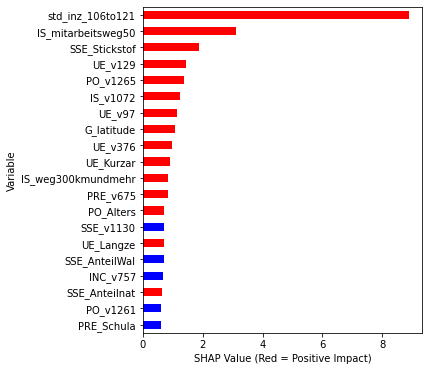

In [9]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

# Second CatBoost model with 20 most important features

In [10]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [11]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9946467718620002


In [12]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  3.3986809440492682


# Compare top 10 features of both Models

In [13]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_106to121', 'IS_mitarbeitsweg50', 'SSE_Stickstof', 'UE_v129', 'PO_v1265', 'IS_v1072', 'UE_v97', 'G_latitude', 'UE_v376', 'UE_Kurzar'] 

 10 most important features from model with top20 features: 
 ['std_inz_106to121', 'IS_mitarbeitsweg50', 'G_latitude', 'IS_v1072', 'SSE_Stickstof', 'UE_v129', 'SSE_AnteilWal', 'UE_v376', 'PO_v1265', 'PO_v1261']


In [14]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_106to121
IS_mitarbeitsweg50
SSE_Stickstof
UE_v129
PO_v1265
IS_v1072
G_latitude
UE_v376


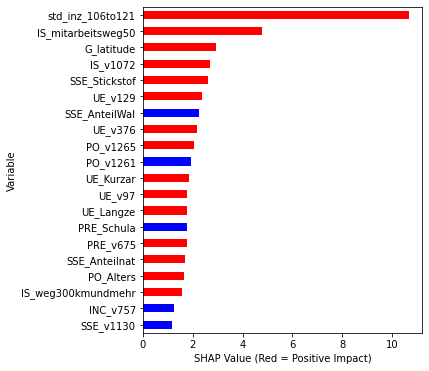

In [15]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

# Hold out validation of the second model

In [16]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [17]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9969479546736768
Mean R2 of linReg_modesl with top20 features:  0.27417854907437356
Mean RMSE of CatBoost_models on test sets with top20 features:  39.04199090585525
Mean R2 of CatBoost_models on test sets with top20 features: 0.21697607143279168


# descriptives of top20 features

In [18]:
X[top20feature].describe()

,std_inz_106to121,IS_mitarbeitsweg50,SSE_Stickstof,UE_v129,PO_v1265,IS_v1072,UE_v97,G_latitude,UE_v376,UE_Kurzar,IS_weg300kmundmehr,PRE_v675,PO_Alters,SSE_v1130,UE_Langze,SSE_AnteilWal,INC_v757,SSE_Anteilnat,PO_v1261,PRE_Schula
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,35.316822,0.243392,68.331619,5.669324,48.195293,531.122192,-8.350618,50.615292,20.240156,0.752618,2.401995,16.566586,2.619949,-86.781784,32.202751,29.393763,8.945635,5.101742,30.637150,6.557357
std,34.207966,1.409296,27.160894,9.243236,1.583288,495.516785,18.685118,1.740311,4.537329,1.440882,0.892102,5.035090,1.530833,6.361413,8.077894,14.751070,2.964479,3.710643,6.028951,2.242232
min,0.000000,-5.300000,21.400000,-22.299999,42.799999,103.000000,-51.700001,47.500000,10.800000,0.000000,0.900000,6.900000,0.000000,-93.599998,10.500000,1.700000,-14.300000,0.900000,9.300000,2.100000
25%,11.892441,-0.400000,47.500000,1.000000,47.400002,223.000000,-21.000000,49.283333,17.000000,0.000000,1.700000,13.000000,1.600000,-88.199997,25.600000,17.500000,7.700000,2.700000,26.400000,4.900000
50%,25.522655,0.500000,59.200001,8.500000,48.400002,360.000000,-9.300000,50.549999,19.299999,0.300000,2.200000,16.100000,2.300000,-87.500000,32.700001,28.799999,9.000000,4.300000,30.500000,6.300000
75%,47.308884,1.100000,88.199997,12.000000,49.200001,617.000000,3.800000,51.849998,22.400000,0.900000,2.900000,19.700001,3.100000,-86.500000,38.500000,40.200001,10.700000,6.300000,35.200001,8.000000
max,223.532379,4.200000,150.699997,26.600000,51.900002,4338.000000,61.299999,54.783333,38.500000,19.600000,5.900000,38.000000,8.900000,0.000000,53.400002,64.099998,24.700001,34.000000,44.099998,16.700001


In [19]:
pd.DataFrame(Y).describe()

,std_inz_later121
count,401.000000
mean,43.944202
std,46.509815
min,0.904054
25%,17.479307
50%,30.933710
75%,56.686890
max,549.691467


In [20]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives5.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 5')